In [1]:
import numpy as np

datasets = ['train', 
            'instrument_ADIR1995', 'instrument_ADIR2003', 
'instrument_ADOS_Module1', 'instrument_ADOS_Module2', 'instrument_ADOS_Module3', 'instrument_ADOS_Module4', 'instrument_ADOS2_Module_Toddler',
'instrument_SRS_Adult', 'instrument_SRS_Child', 
            'entry']

# load data
actual_data = [[None]*5 for _ in datasets]
for fold in range(0, 5):
    for i, d in enumerate(datasets):
        filename = '../data/all_samples_ordinal_gender_cv%d_%s.npy' % (fold, d)
        print('Loading', filename)
        actual_data[i][fold] = np.load(filename)


Loading ../data/all_samples_ordinal_gender_cv0_train.npy
Loading ../data/all_samples_ordinal_gender_cv0_instrument_ADIR1995.npy
Loading ../data/all_samples_ordinal_gender_cv0_instrument_ADIR2003.npy
Loading ../data/all_samples_ordinal_gender_cv0_instrument_ADOS_Module1.npy
Loading ../data/all_samples_ordinal_gender_cv0_instrument_ADOS_Module2.npy
Loading ../data/all_samples_ordinal_gender_cv0_instrument_ADOS_Module3.npy
Loading ../data/all_samples_ordinal_gender_cv0_instrument_ADOS_Module4.npy
Loading ../data/all_samples_ordinal_gender_cv0_instrument_ADOS2_Module_Toddler.npy
Loading ../data/all_samples_ordinal_gender_cv0_instrument_SRS_Adult.npy
Loading ../data/all_samples_ordinal_gender_cv0_instrument_SRS_Child.npy
Loading ../data/all_samples_ordinal_gender_cv0_entry.npy
Loading ../data/all_samples_ordinal_gender_cv1_train.npy
Loading ../data/all_samples_ordinal_gender_cv1_instrument_ADIR1995.npy
Loading ../data/all_samples_ordinal_gender_cv1_instrument_ADIR2003.npy
Loading ../data/al

In [2]:
from collections import defaultdict

# accuracy, rmse, kappa
metrics = defaultdict(list)

In [3]:
from sklearn.metrics import cohen_kappa_score, accuracy_score


# calculate baseline (median imputation)
model='median'
rmse = lambda x, y: np.sqrt(np.mean((x-y)**2))
ks = [5, 7, 10, 12, 15, 17, 20]

for j, d in enumerate(datasets):
    if d != 'train':
        for i, k in enumerate(ks):
            metrics[('accuracy', model, d)] = []
            metrics[('kappa', model, d)] = []
            metrics[('rmse', model, d)] = []
            metrics[('L1', model, d)] = []
            metrics[('wrong', model, d)] = []
d = 'instrument'
metrics[('accuracy', model, d)] = []
metrics[('kappa', model, d)] = []
metrics[('rmse', model, d)] = []
metrics[('L1', model, d)] = []
metrics[('wrong', model, d)] = []

for fold in range(0, 5):
    print(fold)
    train_data = actual_data[datasets.index('train')][fold]
    baseline_model = np.zeros(train_data.shape, dtype=int)
    for col_i in range(train_data.shape[1]):
        a = train_data[:, col_i]
        a = a[a!=0]
        if a.shape[0] != 0:
            m = int(np.median(a))
            baseline_model[:, col_i] = m
    
    inst_true_values = []
    inst_pred_values = []
    for j, d in enumerate(datasets):
        if d != 'train':
            true_values = actual_data[j][fold]

            indices = true_values!=0
            true_values = true_values[indices]
            predicted_values = baseline_model[indices]
                
            metrics[('accuracy', model, d)].append(accuracy_score(true_values, predicted_values))
            metrics[('kappa', model, d)].append(cohen_kappa_score(true_values, predicted_values))
            metrics[('rmse', model, d)].append(rmse(true_values, predicted_values))
            metrics[('L1', model, d)].append(np.linalg.norm(true_values-predicted_values, 1)/true_values.shape[0])
            wrong_indices = np.where(true_values != predicted_values)[0]
            metrics[('wrong', model, d)].append(np.linalg.norm(true_values[wrong_indices]-predicted_values[wrong_indices], 1)/wrong_indices.shape[0])
                
            if d.startswith('instrument'):
                inst_true_values.append(true_values)
                inst_pred_values.append(predicted_values)
    d = 'instrument'
    tv = np.concatenate(inst_true_values)
    pv = np.concatenate(inst_pred_values)
    metrics[('accuracy', model, d)].append(accuracy_score(tv, pv))
    metrics[('kappa', model, d)].append(cohen_kappa_score(tv, pv))
    metrics[('rmse', model, d)].append(rmse(tv, pv))
    metrics[('L1', model, d)].append(np.linalg.norm(tv-pv, 1)/tv.shape[0])
    wrong_indices = np.where(tv != pv)[0]
    metrics[('wrong', model, d)].append(np.linalg.norm(tv[wrong_indices]-pv[wrong_indices], 1)/wrong_indices.shape[0])
                

0
1
2
3
4


In [10]:
model = 'mult_gender'

# pull options for each column
with open('../data/all_samples_ordinal_cleaned_map.txt', 'r') as f:
    num_options = [int(line.split('\t')[1]) for line in f]
    
# load imputed data
imputed_data = [[None]*5 for _ in ks]
for i, k in enumerate(ks):
    for fold in range(0, 5):
        filename = '../gender_models/impute_%s_cv_k%d_fold%s' % (model, k, fold)
        print('Loading', filename)
        try:
            imputed_data[i][fold] = np.load(filename + '.npy')
        except FileNotFoundError:
            try:
                if 'quad' in filename:
                    A = np.loadtxt(filename + '.csv', delimiter=',', dtype=float)

                    # need to round responses
                    A = np.around(A) 
                    for j in range(A.shape[1]):
                        if num_options[j] == 2:
                            A[A[:, j]<=0, j] = -1
                            A[A[:, j]>0, j] = 1
                        else:
                            A[A[:, j] < 1, j] = 1
                            A[A[:, j] > num_options[j], j] = num_options[j]
                    A = A.astype(int)
                else:
                    converters = dict([(i, lambda s: 1 if s=='true' else -1) for i, num in enumerate(num_options) if num==2])
                    A = np.loadtxt(filename + '.csv', delimiter=',', converters = converters, dtype=int)
                np.save(filename, A)
                imputed_data[i][fold] = A
            except:
                print('Not found')

Loading ../gender_models/impute_mult_gender_cv_k5_fold0
Loading ../gender_models/impute_mult_gender_cv_k5_fold1
Loading ../gender_models/impute_mult_gender_cv_k5_fold2
Loading ../gender_models/impute_mult_gender_cv_k5_fold3
Loading ../gender_models/impute_mult_gender_cv_k5_fold4
Loading ../gender_models/impute_mult_gender_cv_k7_fold0
Loading ../gender_models/impute_mult_gender_cv_k7_fold1
Loading ../gender_models/impute_mult_gender_cv_k7_fold2
Loading ../gender_models/impute_mult_gender_cv_k7_fold3
Loading ../gender_models/impute_mult_gender_cv_k7_fold4
Loading ../gender_models/impute_mult_gender_cv_k10_fold0
Loading ../gender_models/impute_mult_gender_cv_k10_fold1
Loading ../gender_models/impute_mult_gender_cv_k10_fold2
Loading ../gender_models/impute_mult_gender_cv_k10_fold3
Loading ../gender_models/impute_mult_gender_cv_k10_fold4
Loading ../gender_models/impute_mult_gender_cv_k12_fold0
Loading ../gender_models/impute_mult_gender_cv_k12_fold1
Loading ../gender_models/impute_mult_gend

In [11]:

rmse = lambda x, y: np.sqrt(np.mean((x-y)**2))

inst_true_values = defaultdict(list)
inst_pred_values = defaultdict(list)
for j, d in enumerate(datasets):
    if d != 'train':
        for i, k in enumerate(ks):
            print(d, k)
            metrics[('accuracy', model, k, d)] = []
            metrics[('kappa', model, k, d)] = []
            metrics[('rmse', model, k, d)] = []
            metrics[('L1', model, k, d)] = []
            metrics[('wrong', model, k, d)] = []

            for fold in range(0, 5):
                true_values = actual_data[j][fold]
                predicted_values = imputed_data[i][fold]
                
                if predicted_values is not None:
                    indices = true_values!=0
                    true_values = true_values[indices]
                    predicted_values = predicted_values[indices]
                    metrics[('accuracy', model, k, d)].append(accuracy_score(true_values, predicted_values))
                    metrics[('kappa', model, k, d)].append(cohen_kappa_score(true_values, predicted_values))
                    metrics[('rmse', model, k, d)].append(rmse(true_values, predicted_values))
                    metrics[('L1', model, k, d)].append(np.linalg.norm(true_values-predicted_values, 1)/true_values.shape[0])
                    wrong_indices = np.where(true_values != predicted_values)[0]
                    metrics[('wrong', model, k, d)].append(np.linalg.norm(true_values[wrong_indices]-predicted_values[wrong_indices], 1)/wrong_indices.shape[0])
                    
                    if d.startswith('instrument'):
                        inst_true_values[(k, fold)].append(true_values)
                        inst_pred_values[(k, fold)].append(predicted_values)

d = 'instrument'
for k in ks:
    metrics[('accuracy', model, k, d)] = []
    metrics[('kappa', model, k, d)] = []
    metrics[('rmse', model, k, d)] = []
    metrics[('L1', model, k, d)] = []
    metrics[('wrong', model, k, d)] = []
    for fold in range(0, 5):
        if len(inst_true_values[(k, fold)]) > 0 and len(inst_pred_values[(k, fold)]) > 0:
            tv = np.concatenate(inst_true_values[(k, fold)])
            pv = np.concatenate(inst_pred_values[(k, fold)])
            metrics[('accuracy', model, k, d)].append(accuracy_score(tv, pv))
            metrics[('kappa', model, k, d)].append(cohen_kappa_score(tv, pv))
            metrics[('rmse', model, k, d)].append(rmse(tv, pv))
            metrics[('L1', model, k, d)].append(np.linalg.norm(tv-pv, 1)/tv.shape[0])
            wrong_indices = np.where(tv != pv)[0]
            metrics[('wrong', model, k, d)].append(np.linalg.norm(tv[wrong_indices]-pv[wrong_indices], 1)/wrong_indices.shape[0])
           

instrument_ADIR1995 5
instrument_ADIR1995 7
instrument_ADIR1995 10
instrument_ADIR1995 12
instrument_ADIR1995 15
instrument_ADIR1995 17
instrument_ADIR1995 20
instrument_ADIR2003 5
instrument_ADIR2003 7
instrument_ADIR2003 10
instrument_ADIR2003 12
instrument_ADIR2003 15
instrument_ADIR2003 17
instrument_ADIR2003 20
instrument_ADOS_Module1 5
instrument_ADOS_Module1 7
instrument_ADOS_Module1 10
instrument_ADOS_Module1 12
instrument_ADOS_Module1 15
instrument_ADOS_Module1 17
instrument_ADOS_Module1 20
instrument_ADOS_Module2 5
instrument_ADOS_Module2 7
instrument_ADOS_Module2 10
instrument_ADOS_Module2 12
instrument_ADOS_Module2 15
instrument_ADOS_Module2 17
instrument_ADOS_Module2 20
instrument_ADOS_Module3 5
instrument_ADOS_Module3 7
instrument_ADOS_Module3 10
instrument_ADOS_Module3 12
instrument_ADOS_Module3 15
instrument_ADOS_Module3 17
instrument_ADOS_Module3 20
instrument_ADOS_Module4 5
instrument_ADOS_Module4 7
instrument_ADOS_Module4 10
instrument_ADOS_Module4 12
instrument_ADOS

//anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


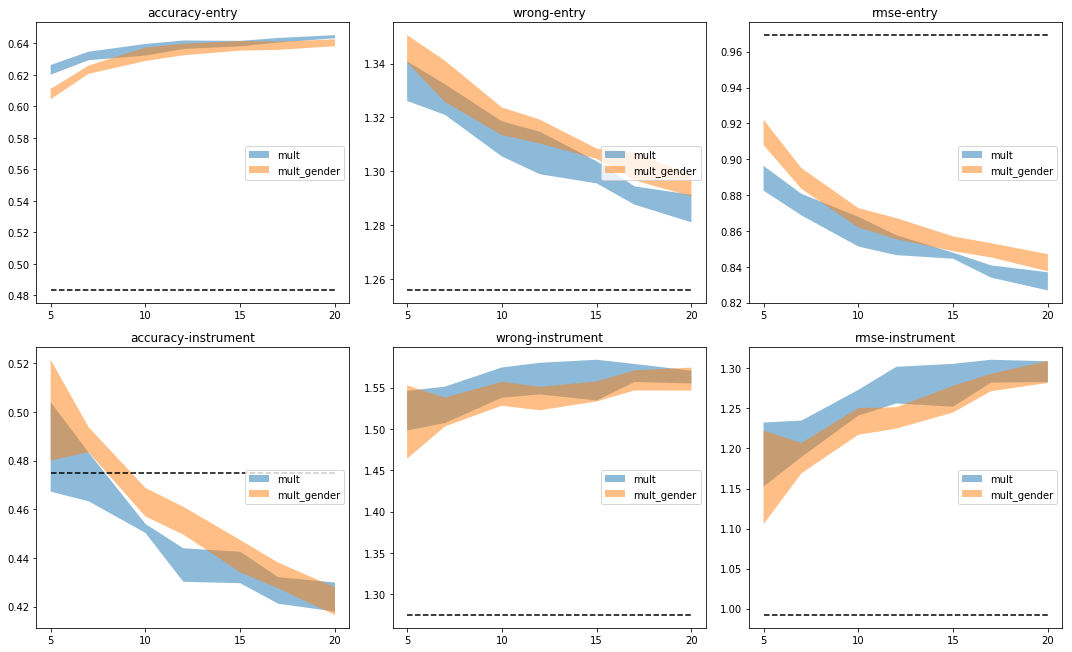

In [9]:
import matplotlib.pyplot as plt
import scipy.stats as st

def calc_conf(a):
    if len(a) == 0:
        return None,
    elif len(a) <= 2:
        return np.mean(a),
    else:
        return st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))

plt.figure(figsize=(15, 45))

mets = ['accuracy', 'wrong', 'rmse']

#for i, d in enumerate(datasets[1:]):
for i, d in enumerate(['entry', 'instrument']):
    for model in ['mult', 'mult_gender']:
        met_ks = [[] for _ in mets]
        for k in ks:
            for j, m in enumerate(mets):
                met_ks[j].append(calc_conf(metrics[(m, model, k, d)]))
           
        for j in range(3):
            plt.subplot(10, 3, i*3+1+j)
            plt.fill_between([k for k, v in zip(ks, met_ks[j]) if len(v) == 2], [x[0] for x in met_ks[j] if len(x) == 2], y2=[x[1] for x in met_ks[j] if len(x) == 2], label=model, alpha=0.5)
            #plt.plot([k for k, v in zip(ks, met_ks[j]) if len(v) == 1 and v[0] is not None], [v[0] for v in met_ks[j] if len(v) == 1 and v[0] is not None], 'o-')

    for j, m in enumerate(mets):
        plt.subplot(10, 3, i*3+1+j)
        plt.title('%s-%s' % (m, d))
        plt.xticks(range(5, 30, 5))
        plt.plot(ks, [np.mean(metrics[(m, 'median', d)]) for k in ks], linestyle='--', color='black')
        plt.legend(loc='right')

plt.tight_layout()
plt.show()

In [107]:
print(metrics[('accuracy', 'bvs', 5, 'entry')])
print(metrics[('rmse', 'bvs', 5, 'entry')])
print(metrics[('kappa', 'bvs', 5, 'entry')])
print(metrics[('accuracy', 'bvs', 5, 'instrument_ADIR2003')])
print(metrics[('rmse', 'bvs', 5, 'instrument_ADIR2003')])
print(metrics[('kappa', 'bvs', 5, 'instrument_ADIR2003')])

[0.6077967566584029, 0.6088192486127536]
[0.8129465081758025, 0.8191290722501351]
[0.4323349562460356, 0.43357960423994957]
[0.5194876427695683, 0.5221808930325427]
[1.0936573226068007, 1.0835059546196684]
[0.30828373373606566, 0.3043854797521921]


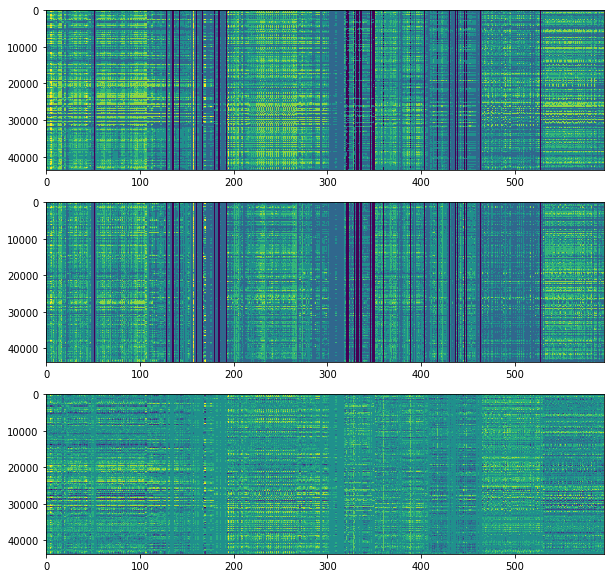

In [78]:
k, fold = 5, 0

A = np.load('../models/impute_%s_cv_k%d_fold%s.npy' % ('quad', k, fold))
B = np.load('../models/impute_%s_cv_k%d_fold%s.npy' % ('ordhing', k, fold))

    plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.imshow(A, aspect='auto')

plt.subplot(3, 1, 2)
plt.imshow(B, aspect='auto')

plt.subplot(3, 1, 3)
plt.imshow(A-B, aspect='auto')

plt.show()

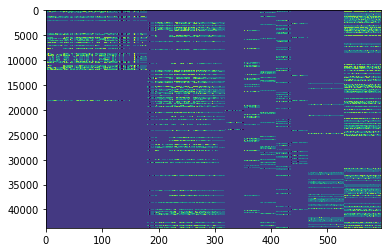

In [133]:
train_data = actual_data[datasets.index('train')][fold]
plt.imshow(train_data, aspect='auto')
plt.show()

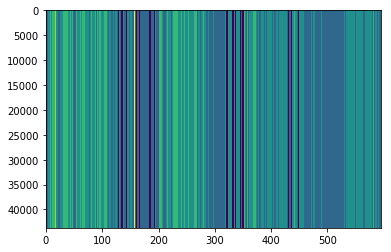

In [137]:
baseline_model = np.zeros(train_data.shape, dtype=int)
for col_i in range(train_data.shape[1]):
    a = train_data[:, col_i]
    a = a[a!=0]
    if a.shape[0] != 0:
        m = int(np.median(a))
        baseline_model[:, col_i] = m
    
plt.imshow(baseline_model, aspect='auto')
plt.show()

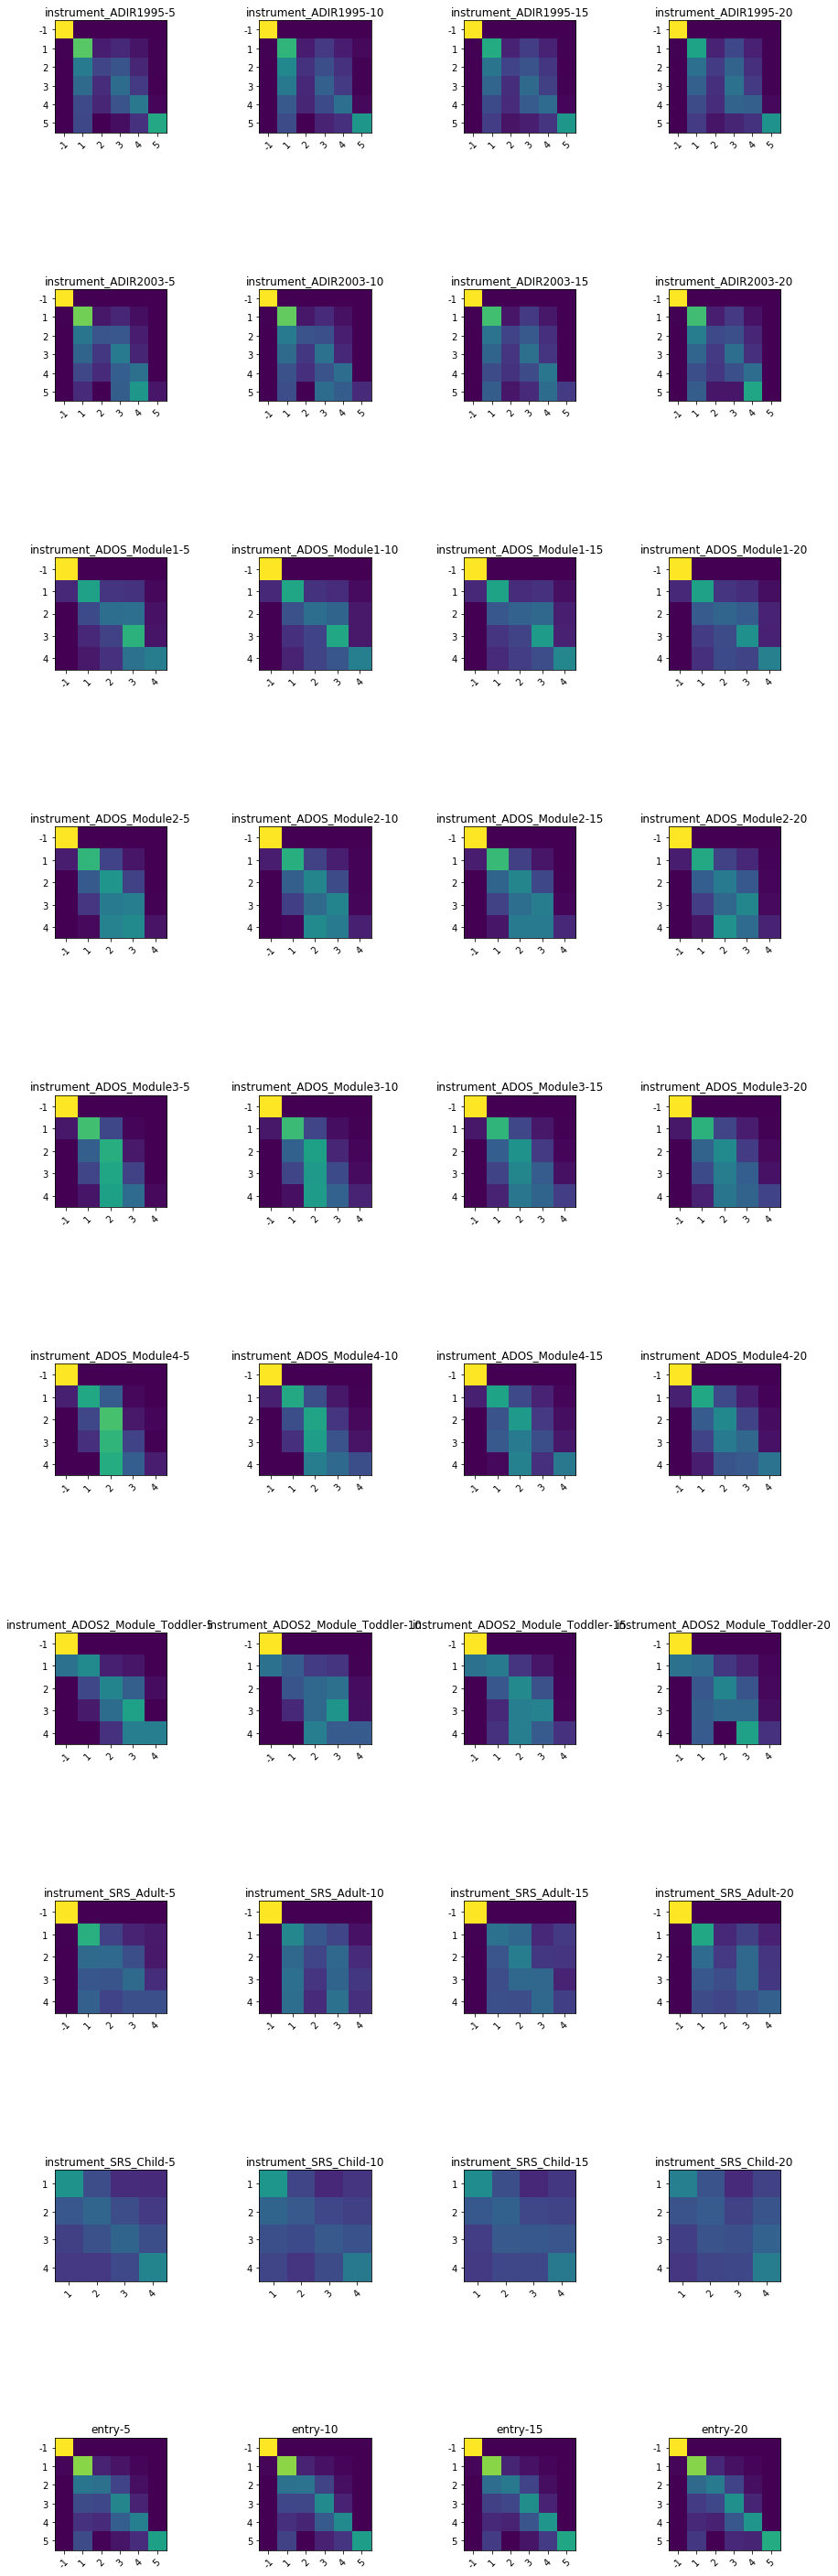

In [16]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(15, 45))

for j, d in enumerate(datasets):
    if d != 'train':
        for i, k in enumerate([5, 10, 15, 20]):
            fold=0
            true_values = actual_data[j][fold]
            predicted_values = imputed_data[i][fold]
                
            if predicted_values is not None:
                indices = true_values!=0
                true_values = true_values[indices]
                predicted_values = predicted_values[indices]
                    
                plt.subplot(11, 5, j*5+i+1)
                cm = confusion_matrix(true_values, predicted_values)
                plt.imshow(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], vmax=1, vmin=0)
                plt.title('%s-%d' % (d, k))
                classes = np.unique(true_values)
                tick_marks = np.arange(len(classes))
                plt.xticks(tick_marks, classes, rotation=45)
                plt.yticks(tick_marks, classes)
                #print(d, k)
                #print(confusion_matrix(true_values, predicted_values))
plt.tight_layout()
plt.show()

In [28]:
import scipy.stats as st

gen, diag, offset, other = [], [], [], []
ks = [5, 7, 10, 12, 15, 17, 20]
for k in ks:
    genv, diagv, offsetv, otherv = [], [], [], []
    for fold in range(5):
        filename = '../gender_models/impute_mult_gender_Y_cv_k%d_fold%d' % (k, fold)
        print('Loading', filename)
        Y = np.loadtxt(filename + '.csv', delimiter=',', dtype=float)

        genv.extend((Y[0, :].flatten()+Y[-1, :].flatten())/2)
        diagv.extend((Y[1, :].flatten()+Y[-1, :].flatten())/2)
        offsetv.extend(Y[-1, :].flatten())
        otherv.extend(Y[2:-1, :].flatten())

    gen.append(st.t.interval(0.95, len(genv)-1, loc=np.mean(genv), scale=st.sem(genv)))
    diag.append(st.t.interval(0.95, len(diagv)-1, loc=np.mean(diagv), scale=st.sem(diagv)))
    offset.append(st.t.interval(0.95, len(offsetv)-1, loc=np.mean(offsetv), scale=st.sem(offsetv)))
    other.append(st.t.interval(0.95, len(otherv)-1, loc=np.mean(otherv), scale=st.sem(otherv)))

Loading ../gender_models/impute_mult_gender_Y_cv_k5_fold0
Loading ../gender_models/impute_mult_gender_Y_cv_k5_fold1
Loading ../gender_models/impute_mult_gender_Y_cv_k5_fold2
Loading ../gender_models/impute_mult_gender_Y_cv_k5_fold3
Loading ../gender_models/impute_mult_gender_Y_cv_k5_fold4
Loading ../gender_models/impute_mult_gender_Y_cv_k7_fold0
Loading ../gender_models/impute_mult_gender_Y_cv_k7_fold1
Loading ../gender_models/impute_mult_gender_Y_cv_k7_fold2
Loading ../gender_models/impute_mult_gender_Y_cv_k7_fold3
Loading ../gender_models/impute_mult_gender_Y_cv_k7_fold4
Loading ../gender_models/impute_mult_gender_Y_cv_k10_fold0
Loading ../gender_models/impute_mult_gender_Y_cv_k10_fold1
Loading ../gender_models/impute_mult_gender_Y_cv_k10_fold2
Loading ../gender_models/impute_mult_gender_Y_cv_k10_fold3
Loading ../gender_models/impute_mult_gender_Y_cv_k10_fold4
Loading ../gender_models/impute_mult_gender_Y_cv_k12_fold0
Loading ../gender_models/impute_mult_gender_Y_cv_k12_fold1
Loading

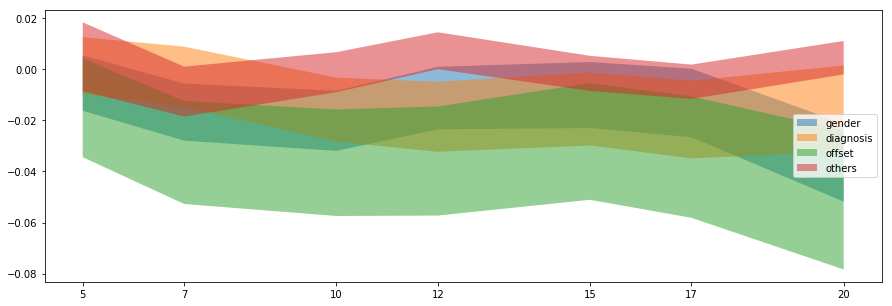

In [29]:
plt.figure(figsize=(15, 5))

#plt.plot(ks, [np.mean(x) for x in gen])
plt.fill_between(ks, [x[0] for x in gen], y2=[x[1] for x in gen], label='gender', alpha=0.5)

#plt.plot(ks, [np.mean(x) for x in diag])
plt.fill_between(ks, [x[0] for x in diag], y2=[x[1] for x in diag], label='diagnosis', alpha=0.5)

#plt.plot(ks, [np.mean(x) for x in offset])
plt.fill_between(ks, [x[0] for x in offset], y2=[x[1] for x in offset], label='offset', alpha=0.5)

#plt.plot(ks, [np.mean(x) for x in other])
plt.fill_between(ks, [x[0] for x in other], y2=[x[1] for x in other], label='others', alpha=0.5)

plt.xticks(ks)
plt.legend(loc='right')

plt.show()

In [45]:
import scipy.stats as st
from collections import defaultdict

gen, diag, offset, other = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
k = 5
for fold in range(5):
    filename = '../gender_models/impute_mult_gender_Y_cv_k%d_fold%d' % (k, fold)
    print('Loading', filename)
    Y = np.loadtxt(filename + '.csv', delimiter=',', dtype=float)

    for i in range(Y.shape[1]):
        gen[i].extend((Y[0, i].flatten()+Y[-1, i].flatten())/2)
        diag[i].extend((Y[1, i].flatten()+Y[-1, i].flatten())/2)
        offset[i].extend(Y[-1, i].flatten())
        other[i].extend(Y[2:-1, i].flatten())


gen = dict([(k, st.t.interval(0.95, len(v)-1, loc=np.mean(v), scale=st.sem(v))) for k, v in gen.items()])
diag = dict([(k, st.t.interval(0.95, len(v)-1, loc=np.mean(v), scale=st.sem(v))) for k, v in diag.items()])
offset = dict([(k, st.t.interval(0.95, len(v)-1, loc=np.mean(v), scale=st.sem(v))) for k, v in offset.items()])
other = dict([(k, st.t.interval(0.95, len(v)-1, loc=np.mean(v), scale=st.sem(v))) for k, v in other.items()])


Loading ../gender_models/impute_mult_gender_Y_cv_k5_fold0
Loading ../gender_models/impute_mult_gender_Y_cv_k5_fold1
Loading ../gender_models/impute_mult_gender_Y_cv_k5_fold2
Loading ../gender_models/impute_mult_gender_Y_cv_k5_fold3
Loading ../gender_models/impute_mult_gender_Y_cv_k5_fold4


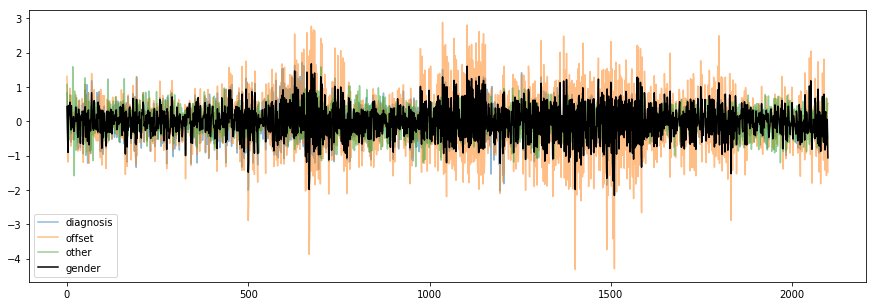

In [46]:
plt.figure(figsize=(15, 5))

#plt.plot(ks, [np.mean(x) for x in gen])
xs = range(len(gen))

#plt.fill_between(xs, [diag[x][0] for x in xs], y2=[diag[x][1] for x in xs], label='diagnosis', alpha=0.5)
plt.plot(xs, [np.mean(diag[x]) for x in xs], label='diagnosis', alpha=0.5)

#plt.fill_between(xs, [offset[x][0] for x in xs], y2=[offset[x][1] for x in xs], label='offset', alpha=0.5)
plt.plot(xs, [np.mean(offset[x]) for x in xs], label='offset', alpha=0.5)

#plt.fill_between(xs, [other[x][0] for x in xs], y2=[other[x][1] for x in xs], label='other', alpha=0.5)
plt.plot(xs, [np.mean(other[x]) for x in xs], label='other', alpha=0.5)

#plt.fill_between(xs, [gen[x][0] for x in xs], y2=[gen[x][1] for x in xs], label='gender', alpha=0.5)
plt.plot(xs, [np.mean(gen[x]) for x in xs], label='gender', color='black')

plt.legend()

plt.show()